# Mechanisms of Action (MoA) Prediction

Helping to develop an algorithm to predict a compound’s MoA given its cellular signature, and thus, helping scientists advance the drug discovery process. [paraphrased] 

<img src="./supp/cells_moa_mike_crop.png">

**The Goal**: "Develop an algorithm that automatically labels each case (in this case, sig_id) in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem."

In other words, the goal is to develop a machine learning algorithm that can correctly (or try to, within some error) classify which drug (or drugs) was inhibitated, based on biological activity. In this scenario, biological activity is defined as gene expressions and cell viability of a sample of 100 cells. Since I did not know what a gene expression or cell viability was at first, I researched. Here's what I found.

1. A gene is a special strand of DNA within a cell. This gene contains, like all other parts of the DNA, a collection of nucleotides. However, the nucleotides within this special strand of DNA (the gene) are in a certain sequence, and this sequence is like a recipe to building proteins for certain functions within the body. It's the sequence of the nucleotides (As, Cs, Ts and Gs) that make a strand of DNA special - and that's a gene!

2. Gene expression is simply the activation of RNA transferring DNA (the gene) to the ribosomes in the cell to do protein synthesis. In other words, think of the gene as a lightbulb. Now, think of the 'expression' as the light swtich. When the lightbulb is turned on (i.e. when the gene is 'expressed'), that's the DNA telling the RNA to begin the journey to protein production. So, we can think of gene expression as what controls the gene's protein production. Note: the type of protein produced can be manipulated based on internal or external factors of the body.

3. Cell Viability is the measurement of healthy, live cells in a population. Though I am not sure how they are measuring cell viability, I do know the values range from -10 to 6.412.  

**Subjects** - that's denoted as sig_id. Harvard collected 100 cell samples from a bunch of subjects (actually, 23,814 subjects to be exact) and mapped those subjects to multiple MoA (Mechanism of Action) responses. These responses are our target values, meaning they are what we will be predicting. There are a total of 206 unique responses. 

**Pertubation Sample Type** - that's denoted as cp_type. It's categorical, with only two values - trt_cp (compound pertubation), and ctl_vehicle (control pertubation). Note that ctl_vehicle has no MoA responses.

**Treatment Duration** - that's denoted as cp_time. It's categorical, with only three values - 24, 48, 72

**Treatmennt Dose** - that's denoted as cp_dose. It's categorical, with only two values - D1 (or high doseage) and D2 (low dosage).

**Gene Expression** - these features are denoted as g- in the data set. It goes from g-0 all the way to g-771.

**Cell Viability** - these features are denoted as c- in the data set. It goes from c-0 all the way to c-99.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4
sns.set_style("darkgrid")

In [2]:
# for the sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# for the linear models that need scaled input data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# for general modeling
from sklearn import model_selection, pipeline, ensemble, metrics, linear_model, svm, neighbors
from sklearn.dummy import DummyClassifier

# for lda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# for tracking how long things take
import time

In [3]:
X = pd.read_csv('train_features.csv')
test = pd.read_csv('test_features.csv')
y = pd.read_csv('train_targets_scored.csv')
#y_notscored = pd.read_csv('train_ys_nonscored.csv')
#sample_submission = pd.read_csv('sample_submission.csv')
y.drop('sig_id',axis=1,inplace=True)

In [4]:
print("Null values present in X: {}".format(X.isnull().any().any()))
print("Null values present in X: {}".format(test.isnull().any().any()))

Null values present in X: False
Null values present in X: False


Plot of Cell Viability (first 10 of 100 cell samples - all subjects)

In [6]:
call_viability_columns = list(X.columns[X.columns.str.contains('c-')])

In [7]:
cell_data = X[call_viability_columns]

In [8]:
cell_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 100 entries, c-0 to c-99
dtypes: float64(100)
memory usage: 18.2 MB


In [9]:
print("Min Cell Viability value: {}".format(cell_data.min().min()))
print("Max Cell Viability value: {}".format(cell_data.max().max()))

Min Cell Viability value: -10.0
Max Cell Viability value: 6.412


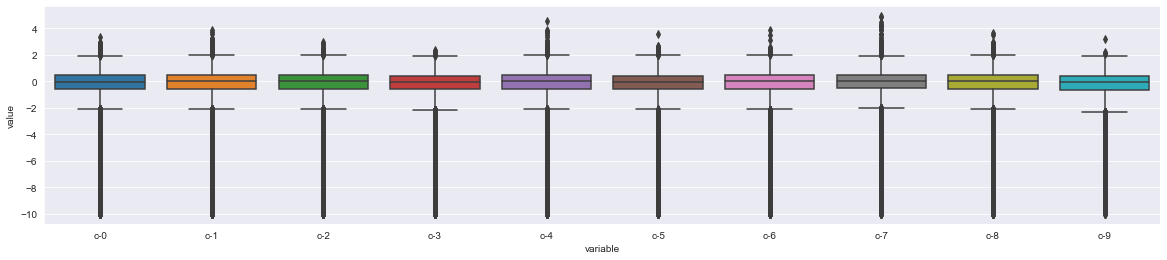

In [12]:
sns.boxplot(x='variable', y='value', data=pd.melt(cell_data.iloc[:,:10]))

The cell viability all looks pretty normally distributed. We can tell by the box of the box-plot - its got the mean line (the horizontal line inside the box) pretty much in the box's center. Let's plot a histrogram of all the cells and see if the underlying distribution of cell viability is normally distributed.

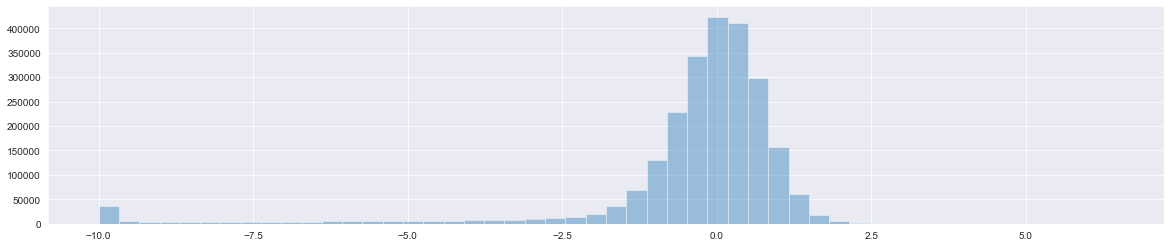

In [125]:
sns.distplot(cell_data.iloc[:,:], kde=False)

In [131]:
# Those outliers! Let's double check.
((cell_data>=-10) & (cell_data<-9)).sum().sum()

46880

Pretty normally distributed. We should note that we get about 40,000 cell samples that have a cell viability value of near -9.0 to -10.0. Those seem like severe outliers, and occur for probably every cell measured for all subjects. At least, this is what the box plot would indicate above. 

Next, let's plot a histogram of the *means* of the cell viability data. We know this will appear normal because of the central limit theorem. 

Since we have 100 cells for each subject, we'll calculate the mean value of all the cell viability values for each subject and plot that histogram.

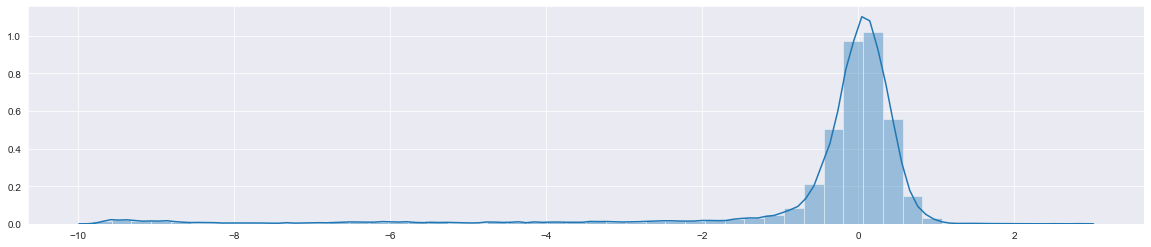

In [147]:
sns.distplot(cell_data.mean(axis=1), kde=True)

In [166]:
print("Mean of our Cell Viability data: {}".format(cell_data.mean(axis=1).mean()))
print("Standard Deviation of our Cell Viability data: {}".format(cell_data.mean(axis=1).std()))

Mean of our Cell Viability data: -0.43223128483244994
Standard Deviation of our Cell Viability data: 1.7320862869924816


Gene expression plots

In [6]:
gene_columns = list(X.columns[X.columns.str.contains('g-')])

In [78]:
gene_data = X[gene_columns]

In [79]:
gene_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 772 entries, g-0 to g-771
dtypes: float64(772)
memory usage: 140.3 MB


In [157]:
print("Min Gene Expression value: {}".format(gene_data.min().min()))
print("Max Gene Expression value: {}".format(gene_data.max().max()))

Min Gene Expression value: -10.0
Max Gene Expression value: 10.0


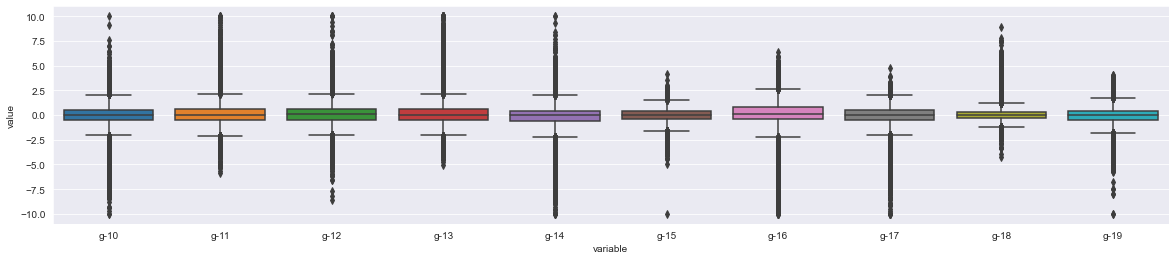

In [108]:
sns.boxplot(x='variable', y='value', data=pd.melt(gene_data.iloc[:,10:20]))

Similar to cell viability, gene expression also appears to be normally distributed. Let's plot a histogram of all the data points (like we did for cell viability). 

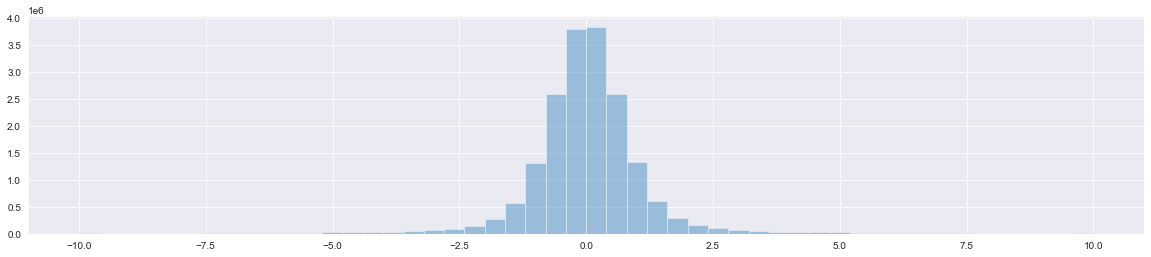

In [132]:
sns.distplot(gene_data.iloc[:,:], kde=False)

Again, like we saw before with cell viability, the gene expression data appears to be normally distributed. We do not have any stark outliers like we did in the cell viability data.

Next, let's plot a histogram of the *means* of the gene expression data. We know this will appear normal because of the central limit theorem.

We have 206 different gene expressions for each subject, so we'll calculate the mean value of all the gene expressions for each subject and plot that histogram.

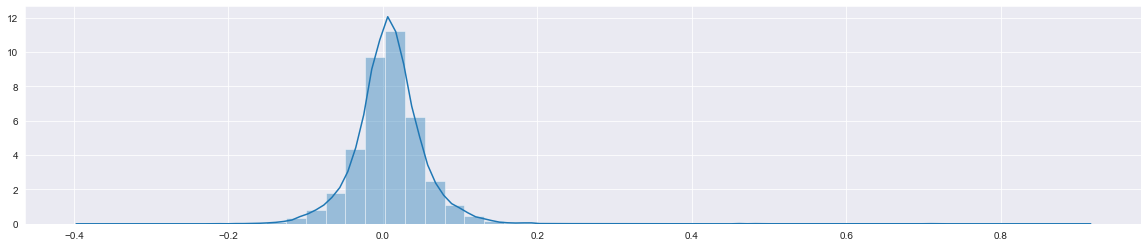

In [162]:
sns.distplot(gene_data.mean(axis=1), kde=True)

In [165]:
print("Mean of our Gene Expression data: {}".format(gene_data.mean(axis=1).mean()))
print("Standard Deviation of our Gene Expression data: {}".format(gene_data.mean(axis=1).std()))

Mean of our Gene Expression data: 0.009009573150247764
Standard Deviation of our Gene Expression data: 0.04866617246751549


### Compound Data (Pertubation Type, Treatment time and Dosage)

In [4]:
compound_columns = ['cp_type', 'cp_time', 'cp_dose']

In [5]:
X_compound_data = X[compound_columns]

In [7]:
X_compound_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cp_type  23814 non-null  object
 1   cp_time  23814 non-null  int64 
 2   cp_dose  23814 non-null  object
dtypes: int64(1), object(2)
memory usage: 558.3+ KB


In [12]:
X_compound_data.apply(pd.Series.value_counts)

,cp_type,cp_time,cp_dose
24,NaN,7772.0,NaN
48,NaN,8250.0,NaN
72,NaN,7792.0,NaN
D1,NaN,NaN,12147.0
D2,NaN,NaN,11667.0
ctl_vehicle,1866.0,NaN,NaN
trt_cp,21948.0,NaN,NaN


From what we can see above, all our compound data is categorical. In other words, these data are not continuous. 

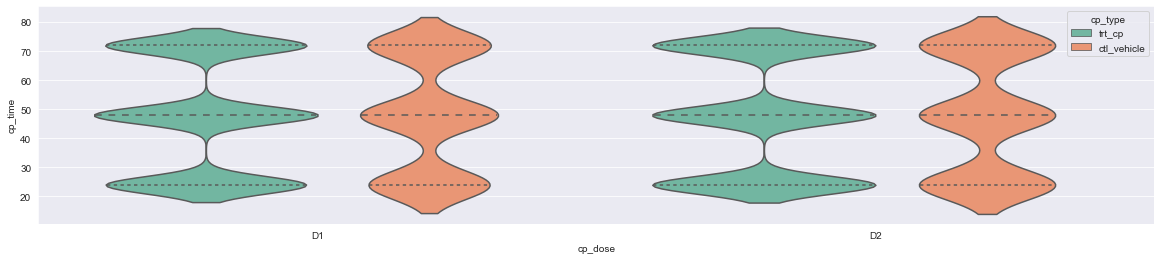

In [145]:
sns.violinplot(x="cp_dose", y="cp_time", hue="cp_type",data=X_compound_data, palette='Set2',inner="quartile")

And from what we can see from the violin plot, the distributions of the compound attributes compared to each other are pretty even! In other words, all three of the compound attributes are shared almost uniformally - for example, there isn't a treatment time that *only* applied to a certain doseage or compound type. 

However, we must note here that there is overall more data for trt_cp than the ctl_vehicle. That's because ctl_vehicle is the control pertubation, meaning subjects that got that pertubation did not receive a drug inhibition. We have less of these control pertubations than actual compound pertubations, because we care more about the cells that actually underwent gene expression changes due to drug inhibition. 

Let's one-hot encode all the data so we can prep it for modeling.

In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [7]:
encoder = OneHotEncoder(sparse=False)

In [8]:
# and also transform the test data
X_compound_data_encoded = pd.DataFrame(encoder.fit_transform(X_compound_data))
X_compound_data_encoded.columns = encoder.get_feature_names()

In [9]:
X_encoded = pd.concat([X.drop(compound_columns,axis=1), X_compound_data_encoded ], axis=1)

In [10]:
# and also transform the test data
test_compound_data = test[compound_columns]
test_compound_data_encoded = pd.DataFrame(encoder.transform(test_compound_data))
test_compound_data_encoded.columns = encoder.get_feature_names()

In [11]:
test_encoded = pd.concat([test.drop(compound_columns,axis=1), test_compound_data_encoded ], axis=1)

### Target Data

In [14]:
y.shape

(23814, 206)

We've got 206 different drugs inhibited, spread across almost 24,000 subjects. The question is in the distribution of these classes.

In [44]:
num_pos_classes = (y==1).sum().sum()
num_neg_classes = (y==0).sum().sum()
print("Only {:.2f}% of all the target values belong to the positive class.".format((num_pos_classes/(num_neg_classes+num_pos_classes))*100))

Only 0.34% of all the target values belong to the positive class.


The above tells us that less than 0.5% of all the possible target values actually belong to the positive class. In other words, our target data is very sparse (lots of zeros). In machine learning, this presents a challenge in both how we model the data (i.e. which algorithm and/or methodology to use), and how we tune the parameters of the model.

### Class Imbalance

In any machine learning problem, we're trying to use data to make predictions. But sometimes the training data we have, specifically the target labels (or in this case, drugs) are imbalanced. What we mean by imbalanced is that we have way more of a negative class (or '0', as it should be labeled) than we do the positive class (or '1'). Class imbalance happens pretty frequently, and thus it's important to know how treat it. 


#### A Note on Accuracy

Accuracy, when used as the scoring method for class-imbalanced datasets, can be misleading.

Assume we measured 100 drug-inhibited subjects, got all their cell viabilities and gene expression data, and then mapped those data to the drug. But what if one of the drugs inhibited was costly, and we didn't have enough of that drug to give to a lot of our subjects? Assume only 2 of the 100 subjects got the costly drug. Now, imagine we wanted to train a classifier to predict the costly drug based on the cell/gene data. In this case, our model would look awesome - it'd be 98% accurate! The model would just predict the negative class (i.e. the subject was not inhibited the costly drug, or '0') all the time.

Is this what we need? It depends. This model would be 100% correct for all the negative classes (our true negative rate would be perfect, 1.0), but it would have 0% accuracy in terms of the positive class (a true postive rate, or sensitivity/recall would be 0). If failing to predict the positive class everytime is costly or even dangerous, then we'd consider the metric accuracy, in this case, to be misleading in terms of the performance of our model. We need to prioritize our true positive rate (the % of samples we correctly classify as having a drug inhibited).

#### Approaches

In this dataset, we have two approaches to the data.

##### 1. Assume there is *mutual exclusivity* amongst the different drugs inhibited to the subject. 
This means that we're assuming there is no correlation between multiple drugs when inhibited to a single subject. In machine learning, we'll approach this type of problem where we train an individual classifier for each drug. However, class imbalance may lead to severe overfitting and high variability in our validation sets due to the sparse nature of the dataset. 

Let's calculate what the imbalance would be for each of the drugs, and check it against a threshold to get a general idea.

In [49]:
moa_class_ratios = (y.T.sum(axis=1)/y.shape[0]).rename('% of positive class')

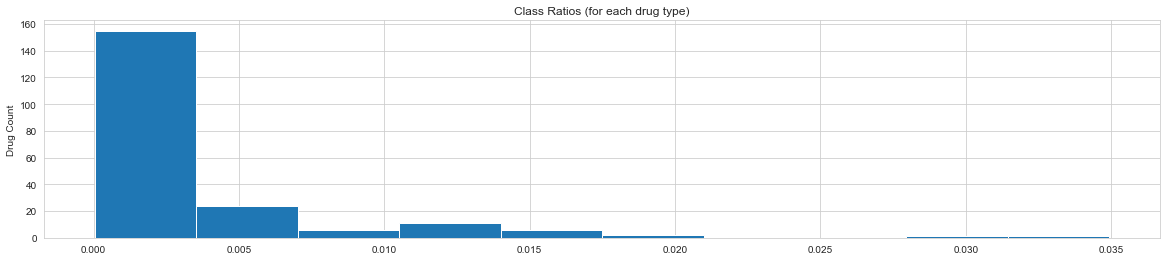

In [54]:
plt.hist(moa_class_ratios)
plt.title('Class Ratios (for each drug type)')
plt.ylabel('Drug Count')
plt.show()

Wow! All the drugs in this dataset have a class imbalance (of the positive class) of at most 3.5% **when looked at individually**. In other words, if we only had one drug, Drug A, and we collected 1,000 subjects's cell and gene expression data, we wouldn't have more than 35 individual subjects mapped to Drug A (or 965 subjects without it). We'll look at the pitfalls of this approach when we do a deep dive later.

##### 2. Assume there is some *mutual inclusivity* amongst the different drugs inhibited to the subjects. 
This means that if there is some correlation between multiple drugs inhibited to a single subject, we'll pick up on that. This is different than the first approach because instead of training individual classifiers for each drug, we'll train one complete classifier for all the drugs.

Let's look at the number of subjects who actually had a drug inhibition mapped to them. We'll count the number of drugs they were mapped towards, and plot that distribution below.

In [47]:
mlbl_count_data = y.sum(axis=1).value_counts()

Text(0.5, 0, '# of multi-labels')

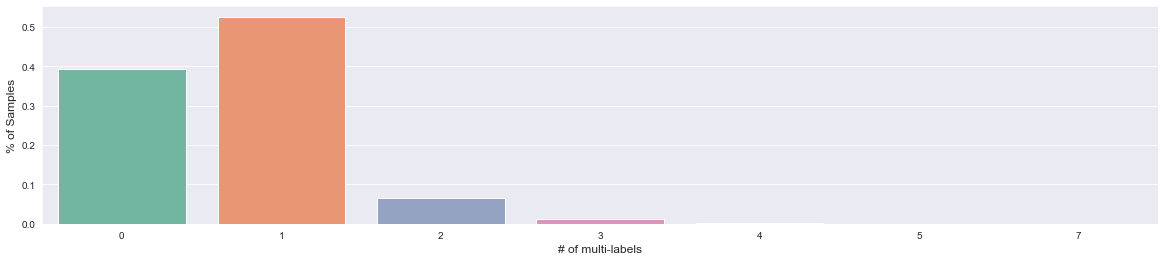

In [24]:
sns.barplot(x=mlbl_count_data.index, y=mlbl_count_data.values/y.shape[0], palette='Set2')
plt.ylabel('% of Samples', fontsize=12)
plt.xlabel('# of multi-labels', fontsize=12)

The above tells you that no more than 7 drugs were inhibited for a single subject. The majority of subjects (about 53%) had only one drug inhibited, and nearly 40% of the subjects didn't have any drugs associated to them! In other words, these subjects were administered either the control pertubation (and not the compound) or their gene expressions did not match any MoAs from the database.

We can summarize this neatly by saying:

1. 39% of the subjects did not have any drugs assocaited (negative label)
2. 53% of the subjects had one drug associated (positive label)
3. And the remaining subjects (8%) had multiple drugs associated (positive label)

We should note that the standard ROC-AUC metric, which is the area under the curve of the True Positive Rate (TPR) and False Positive Rate (FPR), would be misleading for a dataset such as this one. Like accuracy, our ROC-AUC score would be misleading as FPR (the x-axis of the curve) contains information relating to the majority class. We want a metric that focuses solely on the minority class for any of these two reasons:

1. We care more about getting the positive classes correctly predictive (in other words, the True Positive Rate, or 'recall').
2. Our binary classification labels are heavily skewed.

Thus, we'll throw out the FPR and replace it with something called precision. Precision focuses on the minority class. Here's some helpful definitions:
\begin{equation*}
True Positive Rate (TPR) = Recall = \frac{TP}{(TP+FN)}
\end{equation*}
\begin{equation*}
False Positive Rate (FPR) = \frac{FP}{(FP+TN)}
\end{equation*}
\begin{equation*}
Precision = \frac{TP}{(TP+FP)}
\end{equation*}

We'll use the Precision-Recall area under the curve (pr-auc) metric to evaluate the skillfullness of our model, and compare this single value to other models.

## Model

The interesting thing about this dataset is that it's multi-label. Meaning, we've got multiple subjects that were inhibited to one or more combinations of drugs. In order to get probabilities for each drug, we have a few options based on the approaches we talked about above.

Approach#1

    [OnevsRest] - transform this multi-label problem into multiple single-label problems. In other words, train a classifier on the dataset for each of the 206 drugs seperately. The problem here is that we assume mutually *exclusivity* of the labels. If the labels are strongly correlated, then we can probably expect this method to do worse than a method that takes all the labels into account. As we saw before, the classes are very imbalanced (<=3.5% for the positive class), and thus we should expect a great deal of overfitting (low-bias) in our training model, and most likely high variability in the testing sets.

Approach#2
    
    [Neural Network] - Using a single-layer neural network with sigmoid output, we can get probabilities for each drug. This is the preferred method as we'll see later.

### Train-Test Split
Let's generate a hold-out set.

In [12]:
mms = MinMaxScaler()
X_encoded_scaled = pd.DataFrame(mms.fit_transform(X_encoded.drop('sig_id',axis=1)), columns=X_encoded.drop('sig_id',axis=1).columns)

In [13]:
X_train_split, X_test_split, y_train_split, y_test_split = model_selection.train_test_split(X_encoded_scaled, y, 
                                                                                            shuffle=True, random_state=0, test_size=0.15)

In [14]:
# Courtesy of https://www.kaggle.com/lane203j
def pr_auc_score(clf, x, y):
    '''
        This function computes area under the precision-recall curve. 
    '''
      
    precisions, recalls,_ = metrics.precision_recall_curve(y, clf.predict_proba(x)[:,1], pos_label=1)
    
    return metrics.auc(recalls, precisions)

def avg_precision_wrapper(clf, x, y):
    y_prob = clf.predict_proba(x)
    return metrics.average_precision_score(y, y_prob,
                                          average='micro')

def udf_log_loss(clf, x, y):
    
    loss = metrics.log_loss(y, clf.predict_proba(x)[:,1])
    return loss

def imbalanced_cross_validation_score(clf, x, y, cv, scoring, sampler):
    '''
        This function computes the cross-validation score of a given 
        classifier using a choice of sampling function to mitigate 
        the class imbalance, and stratified k-fold sampling.
        
        The first five arguments are the same as 
        sklearn.model_selection.cross_val_score.
        
        - clf.predict_proba(x) returns class label probabilities
        - clf.fit(x,y) trains the model
        
        - x = data
        
        - y = labels
        
        - cv = the number of folds in the cross validation
        
        - scoring(classifier, x, y) returns a float
        
        The last argument is a choice of random sampler: an object 
        similar to the sampler objects available from the python 
        package imbalanced-learn. In particular, this 
        object needs to have the method:
        
        sampler.fit_sample(x,y)
        
        See http://contrib.scikit-learn.org/imbalanced-learn/
        for more details and examples of other sampling objects 
        available.  
    
    '''
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = model_selection.StratifiedKFold(n_splits=cv, random_state=0, shuffle=True)
    
    for train_idx, test_idx in skf.split(x,y):
        
        xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(x.iloc[train_idx],y.iloc[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        train_score = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        test_score  = scoring(clf, x.iloc[test_idx], y.iloc[test_idx])
        
        print("Train: %.2f Test: %.2f"%(train_score,test_score))

        cv_score += test_score
        
    return cv_score/cv

# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs, no_skill_model_name):
    # plot naive skill roc curve
    fpr, tpr, _ = metrics.roc_curve(test_y, naive_probs)
    # get auc score
    auc_noskill =  metrics.roc_auc_score(test_y, naive_probs)
    plt.plot(fpr, tpr, linestyle='--', label='No Skill')
    # plot model roc curve
    fpr, tpr, _ = metrics.roc_curve(test_y, model_probs)
    # get auc score
    auc_modelskill =  metrics.roc_auc_score(test_y, model_probs)
    plt.plot(fpr, tpr, marker='.', label=no_skill_model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the title
    plt.title('No skill AUC={:.2f}, Model Skill AUC={:.2f}'.format(auc_noskill, auc_modelskill))
    # show the plot
    plt.show()    

def plot_pr_curve(test_y, naive_probs, model_probs, no_skill_model_name):
    # plot naive skill pr curve
    recall, precision, _ = metrics.precision_recall_curve(test_y, naive_probs)
    # get auc score
    auc_noskill =  metrics.average_precision_score(test_y, naive_probs,
                                                  average='micro')
    plt.plot(recall, precision, linestyle='--', label='No Skill')
    # plot model pr curve
    recall, precision, _ = metrics.precision_recall_curve(test_y, model_probs)
    auc_modelskill =  metrics.average_precision_score(test_y, model_probs,
                                                  average='micro')
    plt.plot(recall, precision, marker='.', label=no_skill_model_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the title
    plt.title('No skill AUC={:.2f}, Model Skill AUC={:.2f}'.format(auc_noskill, auc_modelskill))
    # show the plot
    plt.show()
    
    
def imb_pipeline(clf, X, y, params, scoring, sampling):
    if sampling==True:
        model = Pipeline([
            ('sampling', RandomOverSampler(sampling_strategy=0.1)),
            ('classification', clf)
        ])
        print('Will sample on train data')
    else:
        model = Pipeline([
            ('classification', clf)
        ])
        print('Note - no sampling being done')
        
    gcv = model_selection.GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scoring, n_jobs=-1,
                       return_train_score=True)
    gcv.fit(X, y)

    return gcv

def sampling_flag(y, threshold):
    '''
    This function takes an nx1 shaped Series and compares the positive class ratio to a given threshold. 
    
    Returns True/False flag used in imb_pipeline 
    '''
    flag = False
    minority_ratio = (y.sum()/y.shape[0])
    if minority_ratio < threshold:
        flag = True
    return flag

In [15]:
# Get a list of all the MoAs to use for modelling
moas = list(y.columns)

### OnevsRest (Approach #1)

#### Logistic Regression
Here's an example using a generalized linear model in Logistic Regression. We'll make sure to scale the data appropriately using MinMaxScaler. This will ensure the cell and gene data are scaled, but also keep the the encoded data (from the categorical pertubation data) as binary.

We'll calculate roc-auc first, then pr-auc for comparison. We want to hit home that roc-auc is misleading for this dataset. Furthermore, we'll look at a dummy classifier and see how this method compares.

In [38]:
drug = 'nfkb_inhibitor'

In [39]:
y_train_split[drug].value_counts()

0    19533
1      708
Name: nfkb_inhibitor, dtype: int64

This drug has 708 positive subjects (about 3.5% of all the labels).

In [40]:
lr_pipeline  = pipeline.Pipeline([('clf', linear_model.LogisticRegression(C=1.0,solver='sag',max_iter = 500,n_jobs=-1))])

In [41]:
ts = time.time()
lr_pipeline.fit(X_train_split, y_train_split[drug])
lr_pipeline_yhat = lr_pipeline.predict_proba(X_test_split)
lr_pipeline_pos_probs = lr_pipeline_yhat[:, 1]
# calculate roc auc
lr_roc_auc = metrics.roc_auc_score(y_test_split[drug], lr_pipeline_pos_probs)
print('Skill ROC AUC %.3f' % lr_roc_auc)
time.time() - ts

Skill ROC AUC 0.966


32.569037675857544

In [42]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_split, y_train_split[drug])
dummy_yhat = dummy.predict_proba(X_test_split)
dummy_pos_probs = dummy_yhat[:, 1]
# calculate roc auc
dummy_roc_auc = metrics.roc_auc_score(y_test_split[drug], dummy_pos_probs)
print('No Skill ROC AUC %.3f' % dummy_roc_auc)

No Skill ROC AUC 0.486


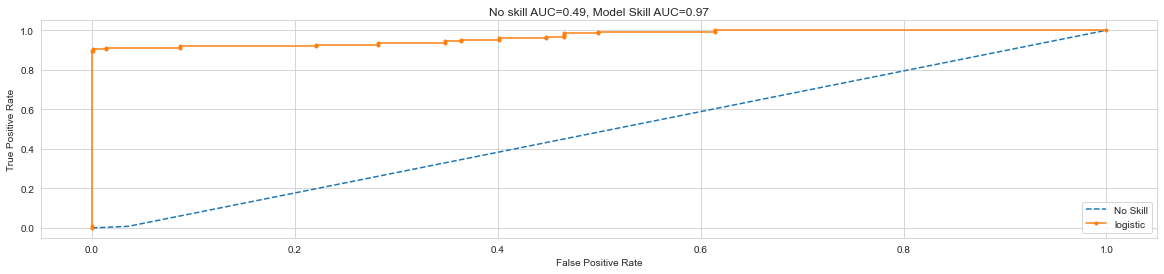

In [43]:
plot_roc_curve(y_test_split[drug],dummy_pos_probs,lr_pipeline_pos_probs,'logistic')

Note that the auc-roc score is misleading. According to this score, our model splits the labels extremely well, and outperforms the 'no skill' model by ~ 90%. We achieve a sensitivity (TPR) close to 90% with at most 10% FPR.

If we plot the probabilities for the test split, we'll notice the nice split. **Note**: the probabilities are for the positive class.

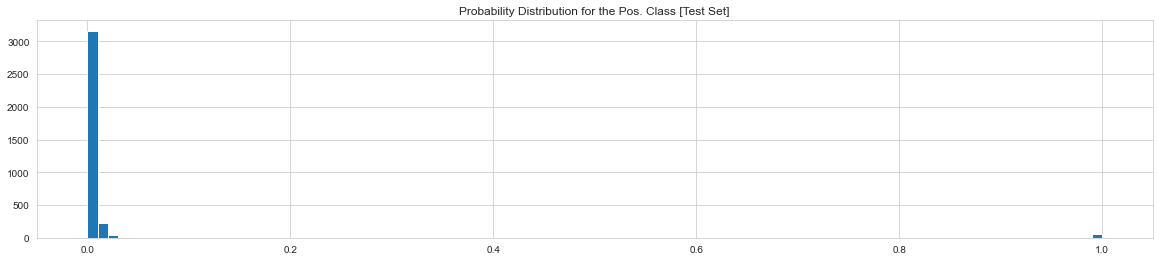

In [44]:
plt.hist(lr_pipeline_pos_probs, bins=100)
plt.title('Probability Distribution for the Pos. Class [Test Set]')
plt.show()

Obviously, our classifier is predicting near zero probability for every subject since the majority are of the negative class. We do have some probabilities near 1.0, however. Since the probs are split evenly, let's just plot a confusion matrix (threshold=0.5) and see what we get.

In [61]:
lr_drug_report = metrics.classification_report(y_test_split[drug], (lr_pipeline_pos_probs>0.5).astype("int32"))
print(lr_drug_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3449
           1       0.99      0.90      0.94       124

    accuracy                           1.00      3573
   macro avg       0.99      0.95      0.97      3573
weighted avg       1.00      1.00      1.00      3573



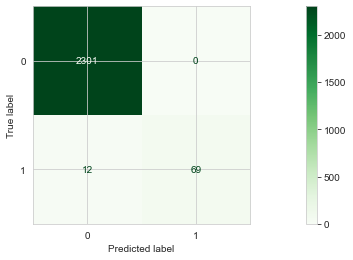

In [50]:
metrics.plot_confusion_matrix(lr_pipeline, X_test_split, y_test_split[drug], cmap='Greens')
plt.show()

We should note the high amount of subjects belonging to the upper-left quadrant. This quadrant is the True Negative quadrant (all the subjects that were predicted to be of the negative class that actually were). In this dataset, True Negatives (TN) are skewing the roc-auc score because FPR (the x-axis in a roc curve) is a function of TNs. We don't really care all too much about TNs because of the two main reasons we mentioned above. Ideally, we want to maximize the TP and minimize FN. Therefore, let's plot a precision-recall curve and calculate the pr-auc.

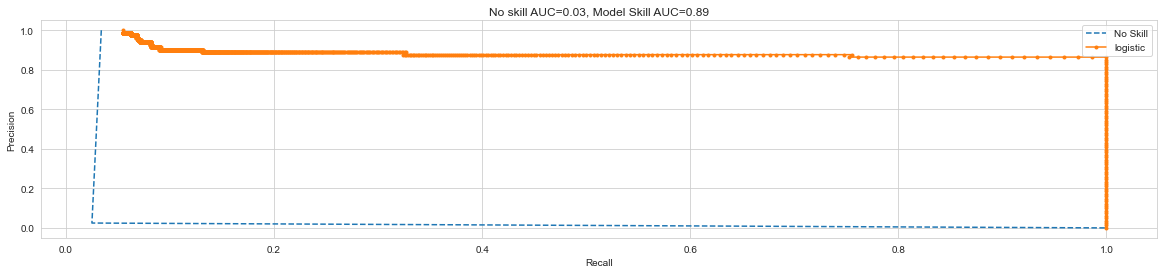

In [51]:
plot_pr_curve(y_test_split[drug],dummy_pos_probs,lr_pipeline_pos_probs,'logistic')

The score is lower than roc-auc, but that's expected. We should use this metric in optimizing our model over cross-validation.

#### Hyperparamter Tuning
Below is an example of hyperparameter tuning. We tune multiple parameters, for two different types of classifiers. We also build a loop for each drug, so we can train individual classifiers for each one. 

Note that we do not actually train a classifier for each drug. This is simply an example of what you would do, but using our example drug ('nfkb_inhibitor').

In [63]:
params = [{'classification__C': (0.005, 0.01, 0.05, 0.1, 0.5)},
          {'classification__n_estimators': (10, 20, 40), 'classification__min_samples_split': (5, 9, 12)}]

classifiers = [('Logistic Regression',
  linear_model.LogisticRegression(max_iter=500, solver='sag',
                     random_state=None,warm_start=False, n_jobs=None)),
 ('Random Forest Classifier',
  ensemble.RandomForestClassifier(verbose=0,
                             warm_start=False, n_jobs=None))]

In [64]:
ts = time.time()
drug_clfs = dict()
for moa in moas[:1]:
    moa = drug
    print('Working on {}'.format(moa))
    best_clf_score = dict()
    for param, classifier in zip(params, classifiers):
        print("Working on {}...".format(classifier[0]))
        clf = imb_pipeline(classifier[1], X_train_split, y_train_split[moa], param, scoring=pr_auc_score, 
                           sampling=sampling_flag(y_train_split[moa], 0.02)) 
        print("Best parameter for {} is {}".format(classifier[0], clf.best_params_))
        print("Best `AUPRC` for {} is {}".format(classifier[0], clf.best_score_))
        best_clf_score[clf.best_estimator_] = clf.best_score_
        print('-'*50)
        print('\n')
    best_estimator = max(best_clf_score, key=best_clf_score.get)
    drug_clfs[moa] = best_estimator

time.time()-ts

Working on nfkb_inhibitor
Working on Logistic Regression...
Note - no sampling being done
Best parameter for Logistic Regression is {'classification__C': 0.5}
Best `AUPRC` for Logistic Regression is 0.8909621452294108
--------------------------------------------------


Working on Random Forest Classifier...
Note - no sampling being done
Best parameter for Random Forest Classifier is {'classification__min_samples_split': 5, 'classification__n_estimators': 10}
Best `AUPRC` for Random Forest Classifier is 0.8911046280687376
--------------------------------------------------




748.3683516979218

We get pretty good pr-auc scores. However, recall this drug had a class imbalance of the positive class of 3.5%. Remeber that a lot of our drugs had way less than 3.5%? If we try a different drug, say '5-alpha_reductase_inhibitor'...

In [59]:
y_train_split['acetylcholine_receptor_antagonist'].sum()/y_train_split.shape[0]

0.012831280328480776

Yikes! That's basically zero. And when that happens, even with sampling techniques, we're not going to get the minority class predicted precisely. But let's try our best with RandomOverSampling, shown below.

In [64]:
ts = time.time()
drug_clfs = dict()
for moa in moas[:1]:
    moa = 'acetylcholine_receptor_antagonist'
    print('Working on {}'.format(moa))
    best_clf_score = dict()
    for param, classifier in zip(params, classifiers):
        print("Working on {}...".format(classifier[0]))
        clf = imb_pipeline(classifier[1], X_train_split, y_train_split[moa], param, scoring=pr_auc_score, 
                           sampling=sampling_flag(y_train_split[moa], 0.02)) 
        print("Best parameter for {} is {}".format(classifier[0], clf.best_params_))
        print("Best `AUPRC` for {} is {}".format(classifier[0], clf.best_score_))
        best_clf_score[clf.best_estimator_] = clf.best_score_
        print('-'*50)
        print('\n')
    best_estimator = max(best_clf_score, key=best_clf_score.get)
    drug_clfs[moa] = best_estimator

time.time()-ts

Working on acetylcholine_receptor_antagonist
Working on Logistic Regression...
Will sample on train data
Best parameter for Logistic Regression is {'classification__C': 0.5}
Best `AUPRC` for Logistic Regression is 0.020530916966896823
--------------------------------------------------


Working on Random Forest Classifier...
Will sample on train data
Best parameter for Random Forest Classifier is {'classification__min_samples_split': 5, 'classification__n_estimators': 40}
Best `AUPRC` for Random Forest Classifier is 0.020216645788755296
--------------------------------------------------




290.73068356513977

As expected, our model is performing terribly. We really cannot trust this method of OnevsRest purely because of the imbalance, which really is inherently created because of the mutual inclusivity of the labels. From now on, let's not assume mutual exclusivity and try different methods or algorithms that support this assumption.

### Neural Network


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Nadam
from keras.metrics import AUC
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.constraints import maxnorm

In [17]:
from scipy.stats import uniform, randint

In [18]:
y_train_split.shape[1]

206

In [19]:
n_features = X_train_split.shape[1]
print(n_features)
output_num = y_train_split.shape[1]
print(output_num)

def create_model(learning_rate=0.001, kernel_initializer='uniform', 
                 activation ='relu', dropout_rate=0.0, weight_constraint=0,
                neurons=200):
    # create model
    model = Sequential()
    model.add(Dense(units=neurons, activation=activation, input_dim=n_features,
                   kernel_initializer = kernel_initializer))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_num, activation='sigmoid', kernel_initializer = kernel_initializer))
    optimizer = Nadam(learning_rate=learning_rate)
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

879
206


In [28]:
history = KerasClassifier(build_fn=create_model).fit(X_train_split, y_train_split, 
                                                     validation_split = 0.15, epochs=15, 
                                                     batch_size=100, verbose=1,  use_multiprocessing=True)

Epoch 1/15
173/173 [==============================] - 1s 7ms/step - loss: 0.0326 - pr-auc: 0.0096 - val_loss: 0.0204 - val_pr-auc: 0.0126
Epoch 2/15
173/173 [==============================] - 1s 6ms/step - loss: 0.0197 - pr-auc: 0.0136 - val_loss: 0.0202 - val_pr-auc: 0.0185
Epoch 3/15
173/173 [==============================] - 1s 6ms/step - loss: 0.0193 - pr-auc: 0.0191 - val_loss: 0.0197 - val_pr-auc: 0.0263
Epoch 4/15
173/173 [==============================] - 1s 6ms/step - loss: 0.0190 - pr-auc: 0.0249 - val_loss: 0.0192 - val_pr-auc: 0.0296
Epoch 5/15
173/173 [==============================] - 1s 6ms/step - loss: 0.0187 - pr-auc: 0.0284 - val_loss: 0.0189 - val_pr-auc: 0.0339
Epoch 6/15
173/173 [==============================] - 1s 6ms/step - loss: 0.0184 - pr-auc: 0.0323 - val_loss: 0.0187 - val_pr-auc: 0.0379
Epoch 7/15
173/173 [==============================] - 1s 6ms/step - loss: 0.0182 - pr-auc: 0.0346 - val_loss: 0.0187 - val_pr-auc: 0.0405
Epoch 8/15
173/173 [==============

Let's plot the loss and validation loss over the epochs. In other words, our learning curve for this network. We do this so we can observe if we're overfitting. Generally, we're expecting validation to be higher than our train loss, and they should be close together.

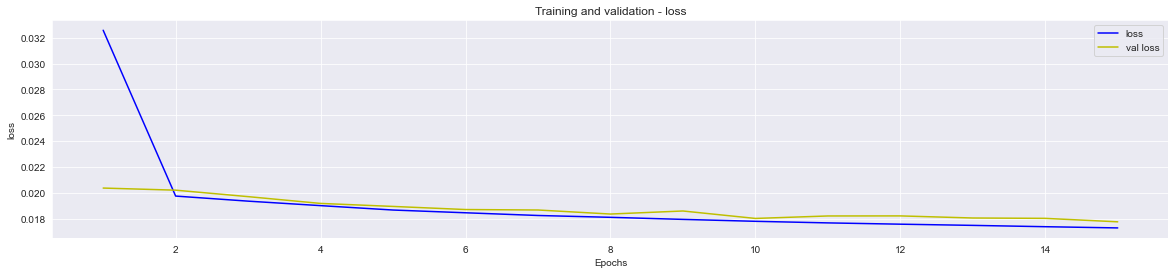

In [29]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

pr_auc_train = history.history['loss']
pr_auc_valid = history.history['val_loss']
plt.plot(epochs, pr_auc_train, 'b', label='loss')
plt.plot(epochs, pr_auc_valid, 'y', label='val loss')
plt.title('Training and validation - loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Looks like we could continue to train this network over more epochs, and expect an improvement in loss. Let's evaluate on the holdout set.

In [77]:
model.evaluate(X_test_split, y_test_split)

112/112 [==============================] - 1s 9ms/step - loss: 0.0171 - pr-auc: 0.0695


[0.017103856429457664, 0.06954441964626312]

Our loss looks good, but that's really because we're mostly predicting 0s for those drugs that have very few positive classes. We know this just by looking at the pr-auc score, which is a dismal 0.07.

So, let's see if we can improve on that holdout set by tuning our hyperparameters using gridsearch. The hyperparameters we'll tune, in order, will be:

1. optimization algorithms
    This is the actual optimization gradiant descent algorithm that's behind the 'learning' of the neural network. We'll try several different optimization methods, choose one, and use that going forward.
2. batch size, training epochs and learning rate
    We'll tune both the batch size (how many training examples we'll take before we update the weights), the epochs (the number of passes through the training set), and the learning rate of the optimizer (the 'step' taken in descent direction that controls the speed at which we converge - too high and we overshoot the minima, too low and we'll either get stuck in an undesirable local minimum, or very slowly converge).
4. network weight initialization
    We'll choose different kernal initializers for each layer of the network. In this case, we have a very simple network of a single layer with activation function ReLU and output of sigmoid.
5. activation functions
6. number of neurons in the hidden layer
    We'll adjust the total number of neurons in the sole hidden layer (along with batch size and epochs again).
7. dropout (regularization)
    If we're overfitting, regularization (dropout) will help here. We'll adjust both the dropout_rate of the Dropout 'layer' and the kernal weight constraint of the Dense layer that procedes it.


In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=1, epochs=100, batch_size=60)

# grid search
batch_size = [40, 60, 80]
epochs = [100, 125, 150]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer = optimizer,
                  #batch_size=batch_size, 
                  #epochs=epochs,
                  )
grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, scoring = avg_precision_wrapper, 
                                    cv=3, return_train_score = True)
grid_result = grid.fit(X_train_split, y_train_split)

In [71]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.297241 using {'optimizer': 'Nadam'}
0.090162 (0.002907) with: {'optimizer': 'SGD'}
0.245594 (0.006091) with: {'optimizer': 'RMSprop'}
0.083633 (0.002808) with: {'optimizer': 'Adagrad'}
0.062216 (0.011043) with: {'optimizer': 'Adadelta'}
0.296191 (0.000708) with: {'optimizer': 'Adam'}
0.291761 (0.002858) with: {'optimizer': 'Adamax'}
0.297241 (0.002759) with: {'optimizer': 'Nadam'}


Looks like we achieve a mean of ~0.3 pr-auc score (with 0.002759 standard deviation) with 'Nadam'. 

Let's sling it with this optimizer. Next, we'll tune the learning rate along with the batch size and epochs.

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# grid search
batch_size = [40, 60, 80]
epochs = [100, 125, 150]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate = learning_rate,
                  batch_size=batch_size, 
                  epochs=epochs,
                  )
grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, scoring = avg_precision_wrapper, 
                                    cv=3, return_train_score = True)
grid_result = grid.fit(X_train_split, y_train_split)

In [77]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.301180 using {'batch_size': 80, 'epochs': 125, 'learning_rate': 0.001}
0.293215 (0.001602) with: {'batch_size': 40, 'epochs': 100, 'learning_rate': 0.001}
0.192665 (0.023245) with: {'batch_size': 40, 'epochs': 100, 'learning_rate': 0.01}
0.014822 (0.000559) with: {'batch_size': 40, 'epochs': 100, 'learning_rate': 0.1}
0.014554 (0.000608) with: {'batch_size': 40, 'epochs': 100, 'learning_rate': 0.2}
0.013856 (0.000825) with: {'batch_size': 40, 'epochs': 100, 'learning_rate': 0.3}
0.292646 (0.009166) with: {'batch_size': 40, 'epochs': 125, 'learning_rate': 0.001}
0.165622 (0.014352) with: {'batch_size': 40, 'epochs': 125, 'learning_rate': 0.01}
0.014992 (0.000311) with: {'batch_size': 40, 'epochs': 125, 'learning_rate': 0.1}
0.013819 (0.001455) with: {'batch_size': 40, 'epochs': 125, 'learning_rate': 0.2}
0.014118 (0.000680) with: {'batch_size': 40, 'epochs': 125, 'learning_rate': 0.3}
0.295685 (0.008336) with: {'batch_size': 40, 'epochs': 150, 'learning_rate': 0.001}
0.169861 (0

From the above, a batch size of 80 with 125 epochs at a learning rate of 0.001 gives us a best possible pr-auc of 0.30118 (0.005327 std).

Next, let's tune the weight initialization between two different activation functions (ReLU and tanh).

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0,
                       batch_size=80, epochs=125, learning_rate=0.001)

# Random search
kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation  = ['relu', 'tanh']
param_grid_dist = dict(kernel_initializer = kernel_initializer, activation=activation)
grid = model_selection.RandomizedSearchCV(estimator=model, param_distributions=param_grid_dist, scoring = avg_precision_wrapper, 
                                    cv=3, return_train_score = True, verbose=10)
grid_result = grid.fit(X_train_split, y_train_split)

In [35]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.302866 using {'kernel_initializer': 'glorot_normal', 'activation': 'relu'}
0.299974 (0.007735) with: {'kernel_initializer': 'normal', 'activation': 'relu'}
0.277493 (0.001552) with: {'kernel_initializer': 'lecun_uniform', 'activation': 'tanh'}
0.015220 (0.000347) with: {'kernel_initializer': 'zero', 'activation': 'relu'}
0.015221 (0.000346) with: {'kernel_initializer': 'zero', 'activation': 'tanh'}
0.302866 (0.006561) with: {'kernel_initializer': 'glorot_normal', 'activation': 'relu'}
0.281643 (0.009131) with: {'kernel_initializer': 'he_uniform', 'activation': 'tanh'}
0.276218 (0.002273) with: {'kernel_initializer': 'he_normal', 'activation': 'tanh'}
0.287295 (0.009916) with: {'kernel_initializer': 'uniform', 'activation': 'tanh'}
0.278358 (0.009522) with: {'kernel_initializer': 'glorot_normal', 'activation': 'tanh'}
0.300741 (0.002385) with: {'kernel_initializer': 'glorot_uniform', 'activation': 'relu'}


In [94]:
randint(1, 5).stats()

(array(2.5), array(1.25))

Seems like the best score we can achieve is with glorot_normal paired with the activation function ReLU in the sole hidden layer. 

Next, let's adjust the number of neurons in the single hidden layer. By the way, <a href="https://en.wikipedia.org/wiki/Universal_approximation_theorem">in theory</a>, a single layer network (which is what we're training) can achieve as good as a result as any other multi-layered network.

We'll also grid search over batch size and epochs as well, as that's good practice when adjusting the hidden layer neuron count.

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, learning_rate=0.001,
                       kernel_initializer='glorot_normal', activation='relu',
                       )

# random search
batch_size = [60, 80, 100]
epochs = [100, 125, 150]
neurons = [600, 800, 1000]
param_grid = dict(neurons = neurons, batch_size=batch_size, epochs = epochs)
grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, scoring = avg_precision_wrapper, 
                                    cv=3, return_train_score = True, verbose=10)
grid_result = grid.fit(X_train_split, y_train_split)

In [104]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.304749 using {'batch_size': 60, 'epochs': 125, 'neurons': 800}
0.299189 (0.003484) with: {'batch_size': 60, 'epochs': 100, 'neurons': 600}
0.301557 (0.004321) with: {'batch_size': 60, 'epochs': 100, 'neurons': 800}
0.296853 (0.005878) with: {'batch_size': 60, 'epochs': 100, 'neurons': 1000}
0.298601 (0.004629) with: {'batch_size': 60, 'epochs': 125, 'neurons': 600}
0.304749 (0.001353) with: {'batch_size': 60, 'epochs': 125, 'neurons': 800}
0.299503 (0.002828) with: {'batch_size': 60, 'epochs': 125, 'neurons': 1000}
0.296374 (0.006269) with: {'batch_size': 60, 'epochs': 150, 'neurons': 600}
0.294901 (0.008113) with: {'batch_size': 60, 'epochs': 150, 'neurons': 800}
0.294403 (0.003244) with: {'batch_size': 60, 'epochs': 150, 'neurons': 1000}
0.302237 (0.002653) with: {'batch_size': 80, 'epochs': 100, 'neurons': 600}
0.302986 (0.004721) with: {'batch_size': 80, 'epochs': 100, 'neurons': 800}
0.299595 (0.007621) with: {'batch_size': 80, 'epochs': 100, 'neurons': 1000}
0.300905 (0.0

Looks like 800 neurons at a batch size and epochs of 60 and 125, respectively, gives us a best mean pr-auc of 0.304749. Note that we hit the floor for the batch size, but considering the results thus far, the tradeoff of not investigating smaller batch sizes is probably small.

Let's tune our regularization (dropout) to see if we can generalize better.

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, learning_rate=0.001,
                       kernel_initializer='glorot_normal', activation='relu',
                       batch_size=60, epochs=125, neurons=800
                       )

# random search
weight_constraint = [1, 2, 3]
dropout_rate = [0.05, 0.1, 0.15]
param_grid = dict(dropout_rate = dropout_rate, weight_constraint=weight_constraint)
grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, scoring = avg_precision_wrapper, 
                                    cv=3, return_train_score = True, verbose=10)
grid_result = grid.fit(X_train_split, y_train_split)

In [106]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.307885 using {'dropout_rate': 0.15, 'weight_constraint': 1}
0.298712 (0.000363) with: {'dropout_rate': 0.05, 'weight_constraint': 1}
0.301443 (0.007521) with: {'dropout_rate': 0.05, 'weight_constraint': 2}
0.307361 (0.003717) with: {'dropout_rate': 0.05, 'weight_constraint': 3}
0.304632 (0.001698) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.307229 (0.004108) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.303351 (0.005510) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.307885 (0.001081) with: {'dropout_rate': 0.15, 'weight_constraint': 1}
0.305700 (0.007244) with: {'dropout_rate': 0.15, 'weight_constraint': 2}
0.305318 (0.004492) with: {'dropout_rate': 0.15, 'weight_constraint': 3}


We can note that with a dropout rate of 0.15 and a weight constraint of 1, we achieve of a score of 0.307885.

### Test on holdout

Now that we've finished tuning the parameters of our model, let's take our tuned model and perform the following:
1. Fit again on the training data
2. Evaluate on the holdout set
3. Plot loss/val_loss

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, learning_rate=0.001,
                       kernel_initializer='glorot_normal', activation='relu',
                       batch_size=60, epochs=125, neurons=800, dropout_rate=0.15,
                        weight_constraint=1
                       )
history = model.fit(X_train_split, y_train_split, validation_split = 0.1, verbose=1)

In [25]:
model.model.evaluate(X_test_split, y_test_split)

112/112 [==============================] - 0s 1ms/step - loss: 0.0155


0.015505846589803696

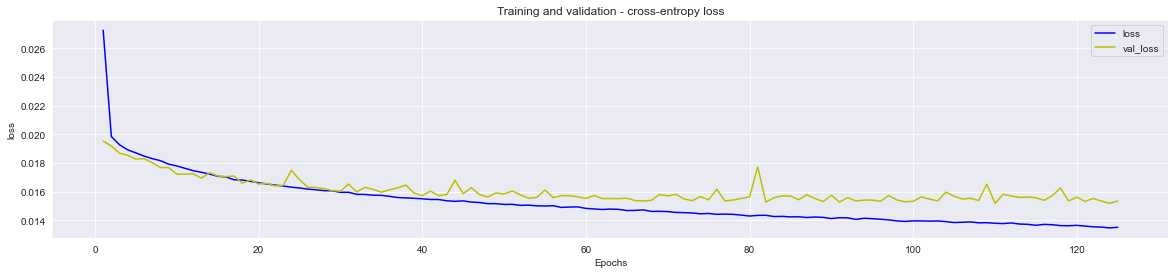

In [26]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'y', label='val_loss')
plt.title('Training and validation - cross-entropy loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

We can note that our model gets increasingly more biased after the 40th epoch or so. 

### Comparing the Tuned Model to the Baseline Model

In our baseline model, we achieved a holdout loss of 0.0171. In our tuned model, we achieved an improvement in loss of 0.0155 (9.4% improvement in loss!).

Here's a summary table below that details not just the scores, but the model parameters.

| Parameters                | Baseline Model \(single layer\) | Tuned Model \(single layer\) |                       |
|---------------------|---------------------------------|------------------------------|-----------------------|
| epochs              | 15                              | 125                          |                       |
| batch\_size         | 100                             | 60                           |                       |
| neurons             | 879                             | 800                          |                       |
| learning\_rate      | 0\.001                          | 0\.001                       |                       |
| optimizer           | adam                            | Nadam                        |                       |
| dropout\_rate       | 0                               | 0\.15                        |                       |
| weight\_constraint  | 0                               | 1                            |                       |
| activation          | ReLU                            | ReLU                         |                       |
| kernal\_initializer | uniform                         | glorot normal                |                       |
| **holdout loss**        | **0\.0171**                        | **0\.0155**                      | **\(9\.4% improvement\)** |

### Resources
I used the following articles for ideas and direction.
https://www.kaggle.com/lane203j/methods-and-common-mistakes-for-evaluating-models
https://www.machinelearningaptitude.com/topics/machine-learning/what-are-the-drawbacks-of-oversampling-minority-class-in-imbalanced-class-problem-of-machine-learning/#:~:text=Training%20set%20is%20further%20split,performance%20on%20the%20test%20set
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

### Misc code (LabelSet, pr-auc graphs, imblean sampling pipelines)

#### Label PowerSet

This next approach assumes there is some dependency among the labels. In other words, there is some correlation between say subject A being inhibited with Drug A and Drug B. Label PowerSet essentially creates new classes based on those combinations and trains on that. The pitfall here is that if unseen data contains combinations of drug labels not seen in training, it's going to get it wrong every time.

This approach is a bit more complicated. For one, I don't know how many combinations of drug inhibitions across subjects there are, and secondly, stratified k-fold might not work in this case. Let's stick with standard k-folds and compute the log loss.

In [41]:
from skmultilearn.problem_transform import LabelPowerset

In [44]:
LabelPowerset(linear_model.LogisticRegression(max_iter=500,
                     random_state=None,warm_start=False, n_jobs=None))

LabelPowerset(classifier=LogisticRegression(max_iter=500),
              require_dense=[True, True])

In [73]:
train_split = pd.concat([X_train_split,y_train_split],axis=1)
train_split_sample = train_split.sample(random_state=0, frac=0.2)
X_train_split_sample = train_split_sample[X_train_split.columns]
y_train_split_sample = train_split_sample[y_train_split.columns]

In [74]:
y_train_split_sample['5-alpha_reductase_inhibitor'].value_counts()

0    4284
1       2
Name: 5-alpha_reductase_inhibitor, dtype: int64

In [81]:
params = [
    {
        'classifier': [ensemble.RandomForestClassifier(n_jobs=None)],
        'classifier__n_estimators': [100], 'classifier__min_samples_split': [5]
    },
]

ts = time.time()
gcv_lp = model_selection.GridSearchCV(LabelPowerset(), params, scoring=avg_precision_wrapper, cv=5,n_jobs=-1, verbose=1)
gcv_lp.fit(X_train_split, y_train_split)

time.time()-ts

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.9min finished


787.1971247196198

In [82]:
gcv_lp.best_score_

0.261560776492898

In [84]:
train_probs = gcv_lp.predict_proba(X_train_split)

In [92]:
train_probs_df = pd.DataFrame(train_probs.toarray(), columns=moas)

In [97]:
train_probs_df[train_probs_df['5-alpha_reductase_inhibitor'] > 0.5]

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
8391,0.502167,0.0,0.0,0.007857,0.013214,0.004286,0.0,0.003333,0.0,0.012500,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.005000,0.0,0.0,0.0000
13862,0.528310,0.0,0.0,0.007500,0.007500,0.000000,0.0,0.007500,0.0,0.003333,...,0.0,0.0,0.0,0.0025,0.0,0.0,0.004167,0.0,0.0,0.0025


In [98]:
gcv_lp.score(X_test_split, y_test_split)

0.26165658179102513

*Note to self - Next steps: *
1. do gcv_lp.predict_proba(X) to get p and r values for all of X. Plot pr curve.
2. Talk about how/why this LP method is better and already shows improvement in score.
3. Look at first drug and calc it's TP.
4. Do HPT with random forest and see what can be achieved. Make sure to **return train scores** as well (and check with cv_results_ after fit and look at bias/variance tradeoff)
5. Can we get xgboost to work here?

In [ ]:
lr_pipeline_LP  = pipeline.Pipeline([('scaler', MinMaxScaler()), ('clf', LabelPowerset(linear_model.LogisticRegression(C=1.0,solver='sag',max_iter = 1000,n_jobs=-1)))])
params = {'C':[1, 10]}
model_selection.GridSearchCV(lr_pipeline_LP, params, scoring=metrics.average_precision_score, cv=3)

In [20]:
probs = lr_pipeline_LP.predict_proba(X_encoded_sample.drop('sig_id',axis=1))

In [21]:
import scipy.sparse
probs_df = pd.DataFrame.sparse.from_spmatrix(probs, columns=y_sample.columns)

In [31]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for col in probs_df.columns[3:4]:
    precision[col], recall[col], _ = metrics.precision_recall_curve(y_sample[col],
                                                        probs_df[col])
    average_precision[col] = metrics.average_precision_score(y_sample[col], probs_df[col])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_sample.values.ravel(),
    probs_df.values.ravel())
average_precision["micro"] = metrics.average_precision_score(np.array(y_sample), np.array(probs_df),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.80


In [32]:
metrics.auc(recall["micro"], precision["micro"])

0.8022297854833816

In [33]:
average_precision["micro"]

0.8022647408631559

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.80')

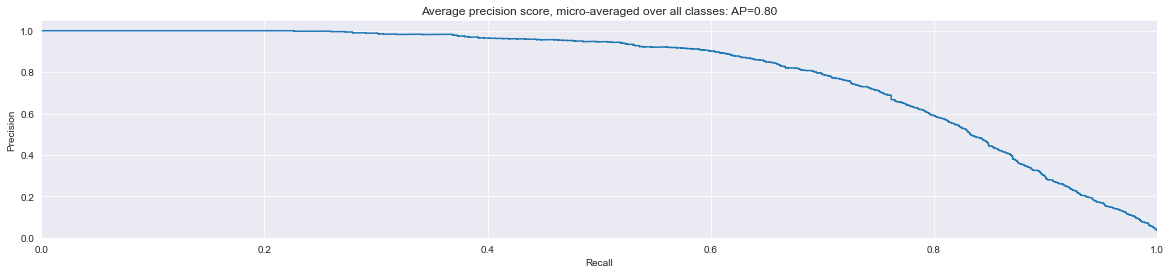

In [25]:
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))